In [39]:
from dataset import generator as data_generation
from dataset import dataset
import models

import json
import numpy as np
import hiddenlayer as hl
import torch.optim as optim
import torch.nn.functional as F


from matplotlib import pyplot as plt
%matplotlib inline

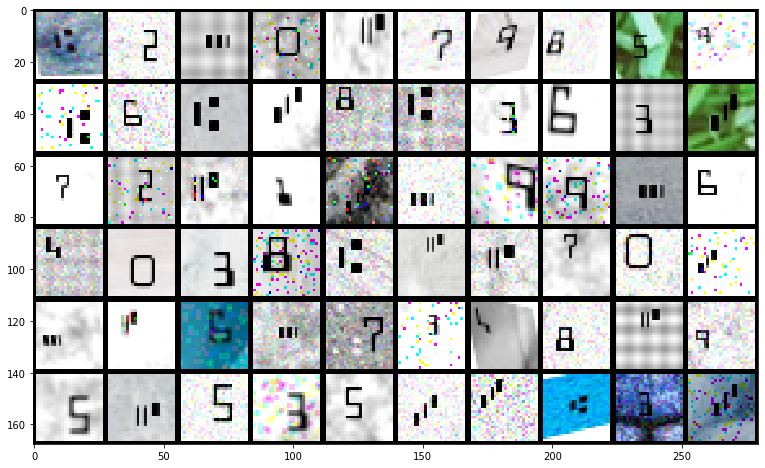

In [2]:
dataset_config = data_generation.base_config
preview_grid = data_generation.make_preview(dataset_config)

plt.figure(figsize=[14, 8])
plt.imshow(preview_grid)

In [3]:
number_of_samples = 50_000
print('Generating synthetic data in directory:', dataset_config['root_directory'], '\nPlease wait')
data_generation.make_dataset(dataset_config, number_of_samples)

Generating synthetic data in directory: ./tmp/MICRST 
Please wait


 10%|█         | 5250/50000 [03:16<23:03, 32.35it/s]  /Users/roszcz/Kody/synthetic-checks-blog/dataset/generator.py:355: RuntimeWarning: invalid value encountered in true_divide
  out /= out.max()
100%|██████████| 50000/50000 [32:50<00:00, 25.38it/s] 


In [33]:
model = models.MicrClassifier().train()
print(model)

MicrClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=14, bias=True)
)


In [34]:
epochs = 32
batch_size = 128
learning_rate = 0.01

optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

learning_rate = 0.01
learning_momentum = 0.5
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=learning_momentum
)

history = hl.History()
canvas = hl.Canvas()

train_loader, test_loader = dataset.make_dataset_loaders(dataset_config, batch_size=batch_size)

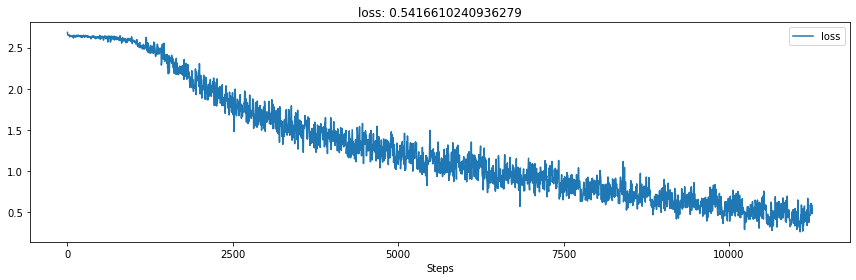

Train Epoch: 32 [25272/45000 (100%)]	Loss: 0.610998


In [35]:
device = 'cpu'
step = 0
for epoch in range(1, epochs+1):
    for batch_idx, sample in enumerate(train_loader):
        data = sample['image'].to(device)
        target = sample['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
                    
        if step % 5 == 0:
            history.log(step, loss=loss)
            canvas.draw_plot([history['loss']])
        step += 1
        
print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    epoch, batch_idx * len(data),
    len(train_loader.dataset),
    100. * batch_idx / len(train_loader),
    loss.item())
)


In [53]:
accuracies = []
for sample in test_loader:
    data = sample['image']
    target = sample['label']
    model_output = model(data)
    accuracy = (model_output.argmax(1) == target).sum().item() / len(target)
    accuracies.append(accuracy)
    
print('Final accuracy:', np.mean(accuracies))

Final accuracy: 0.5765625
